#  MODIS Water Clustering Analysis

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

In [ ]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [50]:
training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0'

GPU = True
TILE = 'Golden'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

num_datapoints = 100

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip', '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip


In [ ]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
              applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Start off with just surface reflectance bands 1,2

### Input data

In [ ]:
colsToDrop = ['sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [ ]:
colsToDrop

In [86]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

Imbalancing data, sampling 0.5 from land, 0.5 from water
subset data shape: (100, 3), (100,)


#### separate the land and water points

In [93]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind = np.where(y>0.5)[0]
y_land_ind = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water = X.iloc[y_water_ind,:]
y_water = y.iloc[y_water_ind]

X_land = X.iloc[y_land_ind,:]
y_land = y.iloc[y_land_ind]

58 58


In [7]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1


In [ ]:
plt.scatter(X_water.values[:,0], X_water.values[:,1],label='Water')
plt.scatter(X_land.values[:,0], X_land.values[:,1],label='Land')
plt.legend()
plt.xlabel(X_water.columns[0])
plt.ylabel(X_water.columns[1])

### kmeans

In [43]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [44]:
%%time
kme =  KMeans(n_clusters=5, **common_params).fit(X)
kmeans_output = kme.predict(X)

CPU times: user 3.77 s, sys: 363 ms, total: 4.13 s
Wall time: 153 ms


In [36]:
print(len(kmeans_output))
print(kmeans_output)
print(kme.cluster_centers_)

100000
[2 0 0 ... 2 4 4]
[[ 198.2939753   138.2729951 ]
 [4741.79561862 4351.71819766]
 [ 831.62718301 2203.31608852]
 [9272.31596091 8476.24680531]
 [2443.03073157 2584.62405947]]


Text(0, 0.5, 'sur_refl_b02_1')

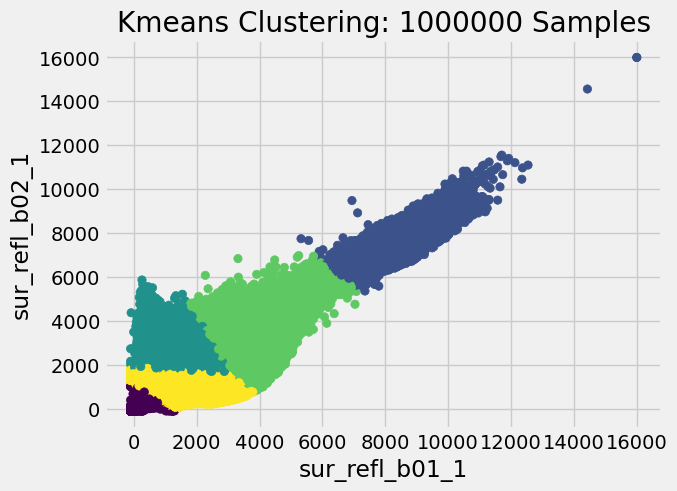

In [45]:
plt.scatter(X.values[:,0], X.values[:,1],c=kmeans_output)
plt.title(f'Kmeans Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

### Birch

In [46]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

MemoryError: unable to allocate array data.

Text(0, 0.5, 'sur_refl_b02_1')

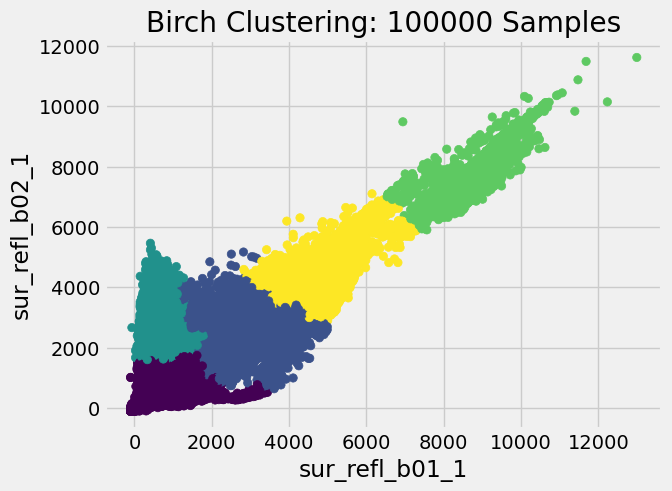

In [39]:
plt.scatter(X.values[:,0], X.values[:,1],c=birch_output)
plt.title(f'Birch Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

### Spectral 

In [17]:
%%time
spectral = SpectralClustering(
        n_clusters=5,
        #affinity="nearest_neighbors",
        random_state=42).fit_predict(X)

CPU times: user 42min 33s, sys: 3min 47s, total: 46min 21s
Wall time: 1min 10s


Text(0, 0.5, 'sur_refl_b02_1')

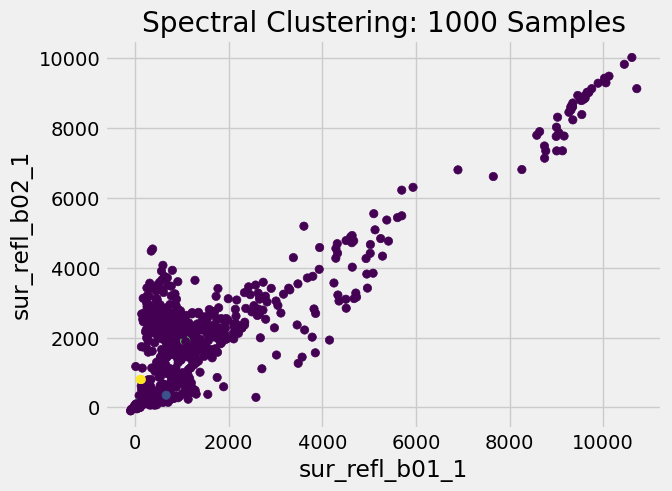

In [20]:
plt.scatter(X.values[:,0], X.values[:,1],c=spectral)
plt.title(f'Spectral Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

## Adding more input bands

In [51]:
colsToDrop = [
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [68]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

Imbalancing data, sampling 0.5 from land, 0.5 from water
subset data shape: (100, 3), (100,)


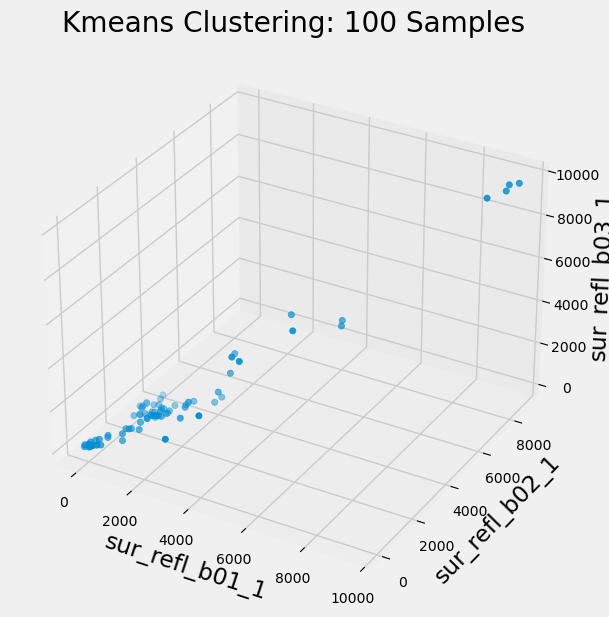

In [77]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o')

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()

### Kmeans

In [70]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [72]:
%%time
kme =  KMeans(n_clusters=5, **common_params).fit(X)
kmeans_output = kme.predict(X)

CPU times: user 67.9 ms, sys: 0 ns, total: 67.9 ms
Wall time: 8.78 ms


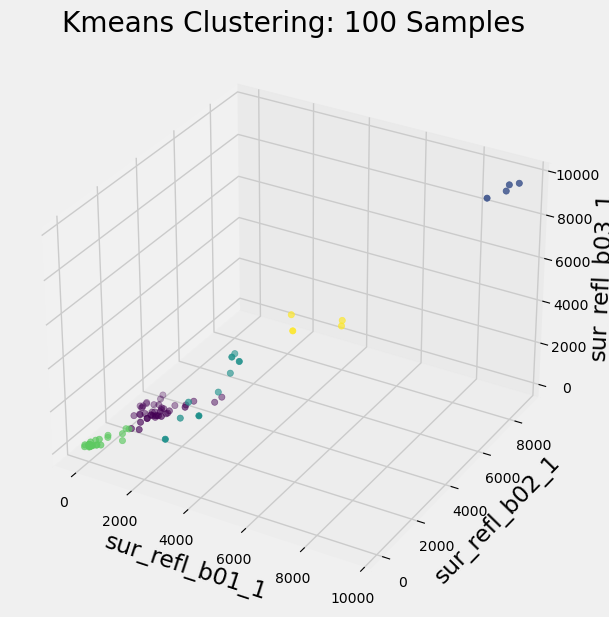

In [78]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
plt.title(f'Kmeans Clustering: {num_datapoints} Samples')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o',c=kmeans_output)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()

### Birch

In [74]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

CPU times: user 12.4 ms, sys: 11 ms, total: 23.4 ms
Wall time: 27.3 ms


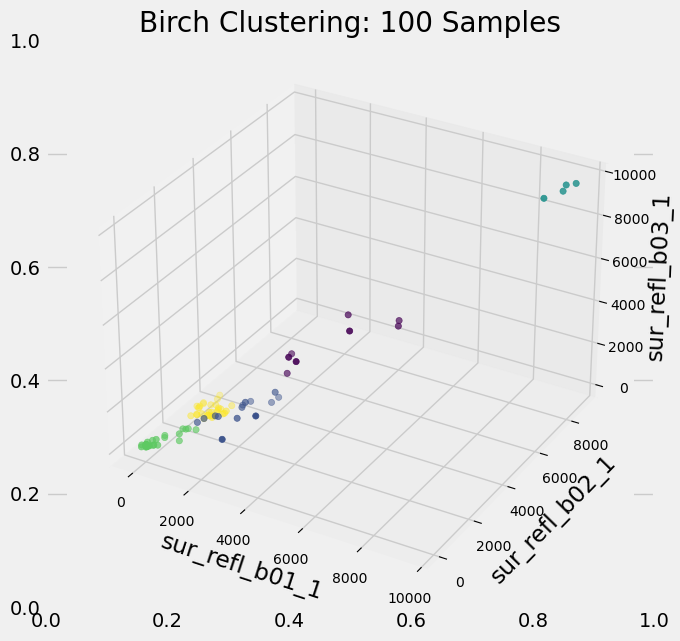

In [76]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Birch Clustering: {num_datapoints} Samples')
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o',c=birch_output)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()